已将项目根目录添加到Python路径: D:\App\Pycharm\1009MovieSchedulingSimulation



✅ 所有模块已成功导入！


In [30]:
import sys
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib

# --- [ 步骤 0: 环境与显示设置 ] ---
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)


In [31]:
# --- [ 步骤 1: 数据加载与预处理 ] ---
print("\n--- 1. 正在加载并预处理评估数据 ---")
csv_path = '../logs/full_evaluation_results.csv'
try:
    df = pd.read_csv(csv_path)
    df['daily_actions'] = df['daily_actions'].apply(json.loads)
    df['daily_incomes'] = df['daily_incomes'].apply(json.loads)
    print(f"✅ 数据加载成功，共 {len(df)} 条模拟记录。")
except FileNotFoundError:
    print(f"❌ 错误：在路径 '{csv_path}' 下找不到结果文件。")
    print("👉 请先确保您已经成功运行了最新的评估脚本 main.py。")
    df = pd.DataFrame()


--- 1. 正在加载并预处理评估数据 ---
✅ 数据加载成功，共 60 条模拟记录。


In [32]:
import numpy as np
import pandas as pd

# (假设 df 变量已经从你之前的步骤加载完毕)

# --- [ 步骤 2: 定义所有分析函数 ] ---
def calculate_sharpe(daily_rewards):
    """计算夏普比率"""
    # 【修改】: 确保 daily_incomes 被正确解析
    # 检查 daily_rewards 是否为字符串（从 CSV 读入时）
    if isinstance(daily_rewards, str):
        try:
            # 假设它是JSON字符串
            daily_rewards = pd.read_json(daily_rewards, typ='series')
        except ValueError:
            return np.nan # 如果解析失败，返回NaN
            
    daily_rewards = np.asarray(daily_rewards)
    
    # 检查标准差是否为0
    std_dev = daily_rewards.std()
    if std_dev == 0 or np.isnan(std_dev):
        return 0.0
        
    return daily_rewards.mean() / std_dev

# --- [ 步骤 3: 计算并展示高级性能与风险指标 (已合并场景) ] ---
if not df.empty:
    print("\n" + "="*80)
    print("### 核心性能与风险稳定性指标分析 (所有日期汇总) ###")
    print("="*80)
    
    # 【修改】: 不再按 'scenario' 分组
    summary_avg = df.groupby('policy')['total_income'].mean()
    
    print("\n--- 核心性能指标：性能提升百分比 ---\n")
    
    sac_policy_name = 'RL (SAC)'
    if sac_policy_name not in summary_avg.index:
        print(f"警告：在结果中找不到主模型 '{sac_policy_name}'，跳过性能提升计算。")
    else:
        sac_income = summary_avg[sac_policy_name]
        
        # 查找包含 'SAC' 的所有策略名
        sac_variants_to_drop = summary_avg.index[summary_avg.index.str.contains('SAC')]
        # 排除所有 'SAC' 变体，剩下的都是基准策略
        baselines_incomes = summary_avg.drop(sac_variants_to_drop)
        
        if not baselines_incomes.empty:
            print(f"在【所有日期】汇总场景下:")
            print(f"  - {sac_policy_name} 平均收入: {sac_income:.2f} 万元")
            
            # ========================= 【【修改点：循环对比所有基准】】 =========================
            print("\n  --- SAC 与各基准策略对比 ---")
            for baseline_name, baseline_income in baselines_incomes.items():
                if baseline_income > 0:
                    improvement_pct = (sac_income / baseline_income - 1) * 100
                    print(f"    - 相对于 {baseline_name:<10} ({baseline_income:.2f} 万): {improvement_pct:+.2f}%")
                else:
                    print(f"    - 无法对比 {baseline_name:<10} (基准收入为0)")
            
            # (保留最佳基准的对比)
            best_baseline_income = baselines_incomes.max()
            best_baseline_name = baselines_incomes.idxmax()
            total_improvement_pct = (sac_income / best_baseline_income - 1) * 100
            print(f"\n  - 最佳基准策略 ({best_baseline_name}): {best_baseline_income:.2f} 万元")
            print(f"  - SAC 性能提升百分比 (相较最佳基准): {total_improvement_pct:.2f}%\n")
            # =================================================================================

        else:
            print(f"在【所有日期】汇总场景下: 没有找到可供对比的基准策略。\n")

    # 【【修改】】: 不再按 'scenario' 分组
    summary_min = df.groupby('policy')['total_income'].min().to_frame(name='最差情况表现 (万元)')
    print("\n--- 风险指标：最差情况表现 (万元) ---\n数值越大，抗风险能力越强：")
    print(summary_min.round(2))

    # 【【修改】】: 确保 daily_incomes 被正确解析
    # 假设 'daily_incomes' 是从 CSV 读入的 JSON 字符串
    df['sharpe_ratio'] = df['daily_incomes'].apply(calculate_sharpe)
    
    # 【【修改】】: 不再按 'scenario' 分组
    summary_sharpe = df.groupby('policy')['sharpe_ratio'].mean().to_frame(name='平均夏普比率')
    print("\n--- 风险指标：平均夏普比率 ---\n数值越大，风险调整后收益越高：")
    print(summary_sharpe.round(2))


### 核心性能与风险稳定性指标分析 (所有日期汇总) ###

--- 核心性能指标：性能提升百分比 ---

在【所有日期】汇总场景下:
  - RL (SAC) 平均收入: 58.35 万元

  --- SAC 与各基准策略对比 ---
    - 相对于 效率启发式策略    (37.31 万): +56.41%
    - 相对于 贪婪启发式策略    (36.82 万): +58.50%
    - 相对于 静态启发式策略    (25.17 万): +131.80%

  - 最佳基准策略 (效率启发式策略): 37.31 万元
  - SAC 性能提升百分比 (相较最佳基准): 56.41%


--- 风险指标：最差情况表现 (万元) ---
数值越大，抗风险能力越强：
          最差情况表现 (万元)
policy               
RL (SAC)         9.08
效率启发式策略          6.23
贪婪启发式策略          8.60
静态启发式策略          4.76

--- 风险指标：平均夏普比率 ---
数值越大，风险调整后收益越高：
          平均夏普比率
policy          
RL (SAC)    1.06
效率启发式策略     1.45
贪婪启发式策略     1.35
静态启发式策略     1.48



### 决策行为诊断指标分析 (关键窗口期：20天) ###

--- 案例分析：高开低走 - 《上海堡垒》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
RL (SAC)    1.0
贪婪启发式策略     4.0
效率启发式策略     5.0
静态启发式策略     NaN
Name: 《上海堡垒》 20天内止损速度 (天), dtype: float64
✅ 图表已保存至: ../plots\上海堡垒_cut_loss_speed_20d_20days_view.png


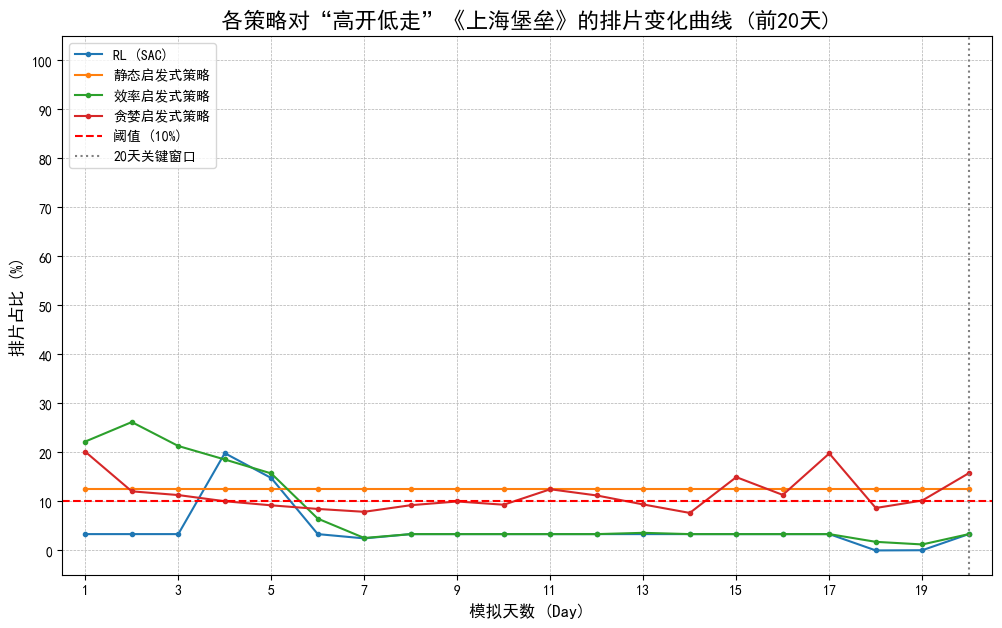


--- 案例分析：高开低走 - 《1917》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
RL (SAC)    1.0
效率启发式策略     NaN
贪婪启发式策略     NaN
静态启发式策略     NaN
Name: 《1917》 20天内止损速度 (天), dtype: float64
✅ 图表已保存至: ../plots\1917_cut_loss_speed_20d_20days_view.png


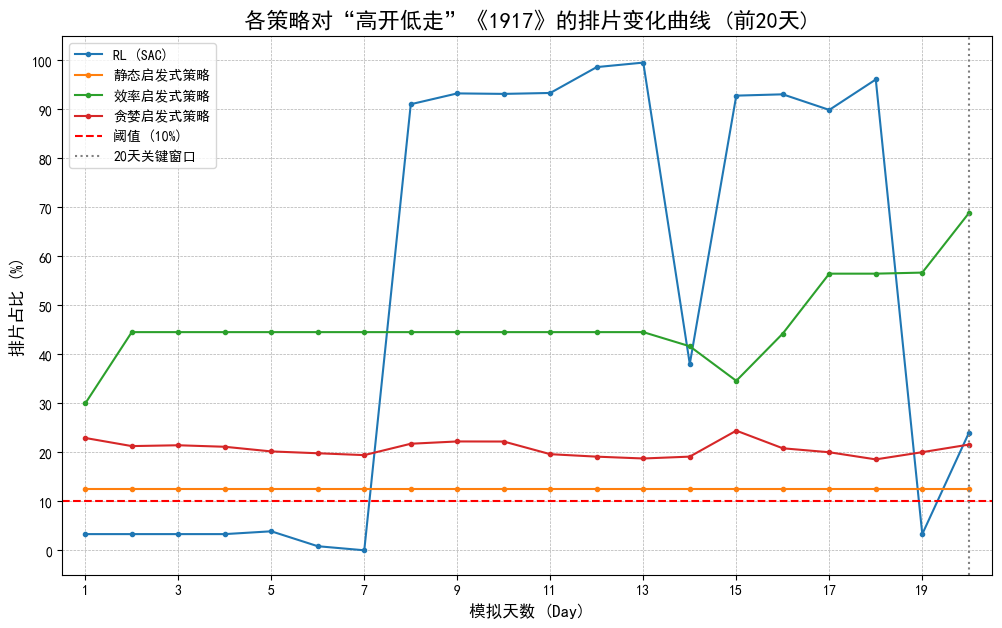


--- 案例分析：高开低走 - 《一秒钟》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
RL (SAC)    1.0
效率启发式策略     NaN
贪婪启发式策略     NaN
静态启发式策略     NaN
Name: 《一秒钟》 20天内止损速度 (天), dtype: float64
✅ 图表已保存至: ../plots\一秒钟_cut_loss_speed_20d_20days_view.png


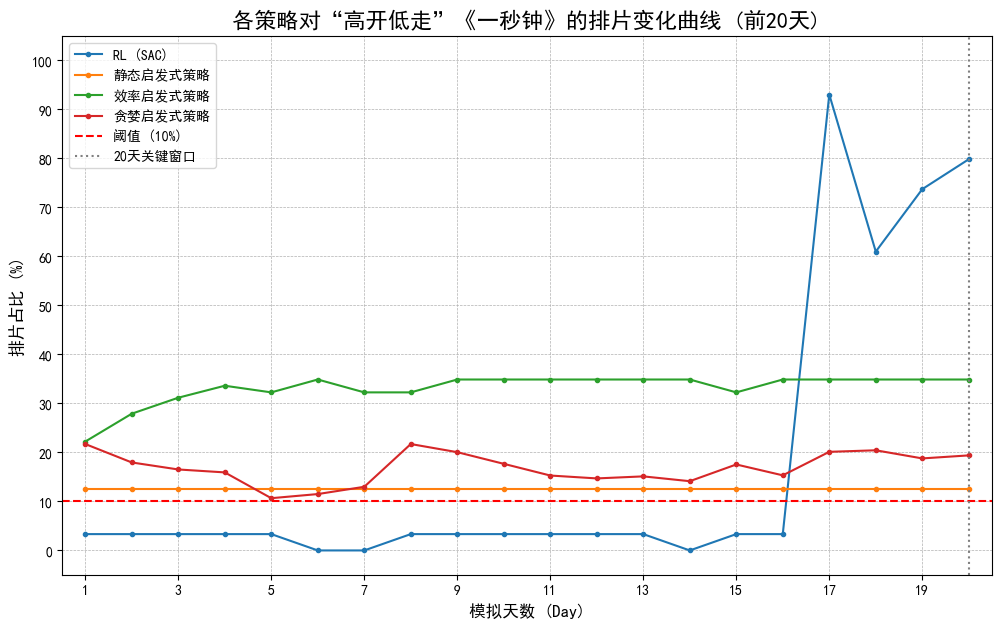


--- 案例分析：高开低走 - 《铁道英雄》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
RL (SAC)    1.0
效率启发式策略     NaN
贪婪启发式策略     NaN
静态启发式策略     NaN
Name: 《铁道英雄》 20天内止损速度 (天), dtype: float64
✅ 图表已保存至: ../plots\铁道英雄_cut_loss_speed_20d_20days_view.png


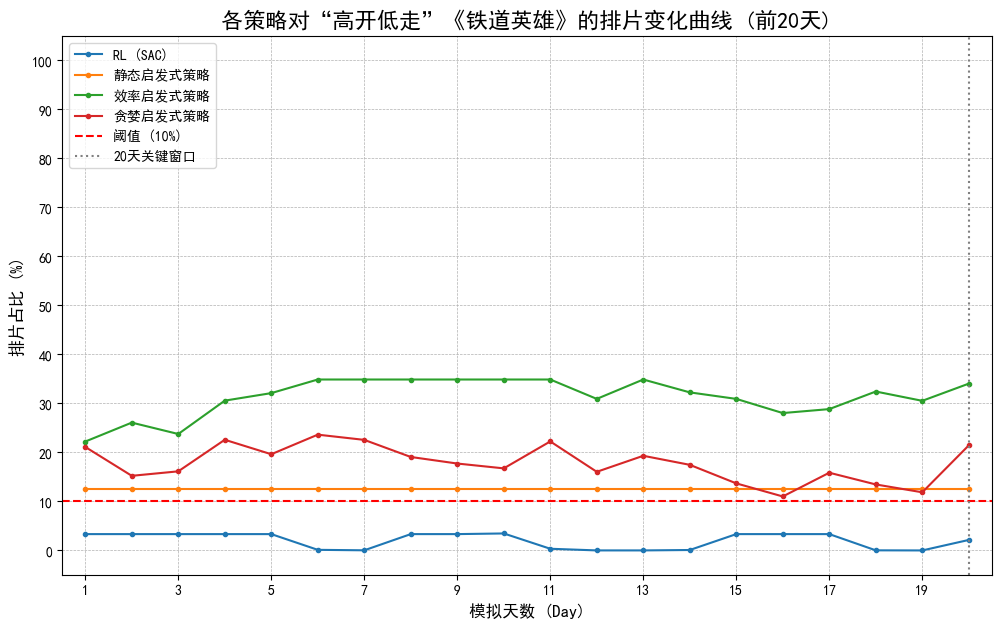


--- 案例分析：高开低走 - 《神秘海域》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
RL (SAC)    3.0
效率启发式策略     NaN
贪婪启发式策略     NaN
静态启发式策略     NaN
Name: 《神秘海域》 20天内止损速度 (天), dtype: float64
✅ 图表已保存至: ../plots\神秘海域_cut_loss_speed_20d_20days_view.png


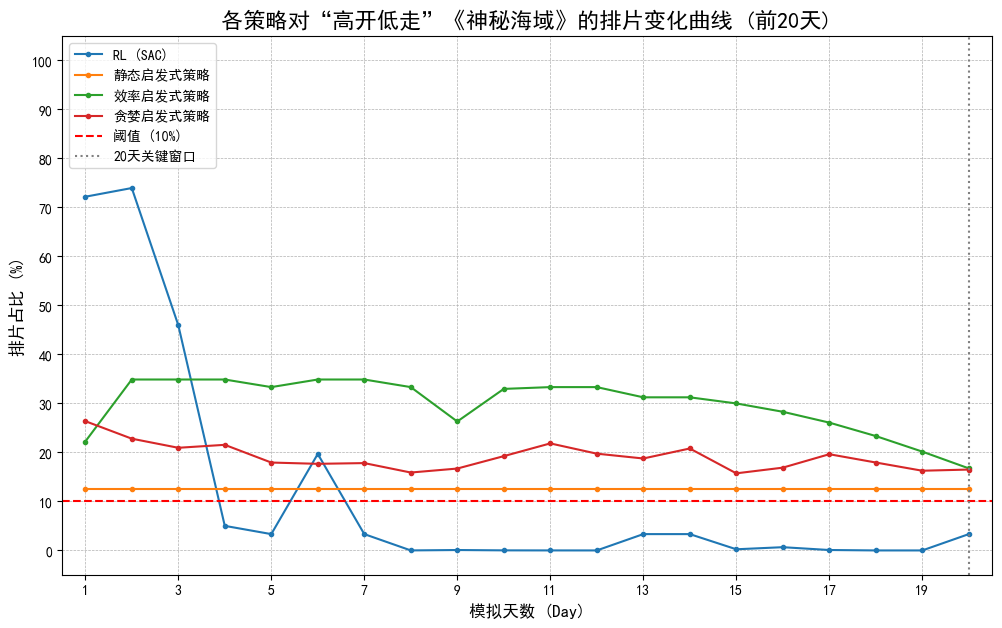


--- 案例分析：高开低走 - 《哆啦A梦：大雄的宇宙小战争2021》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
RL (SAC)     1.0
贪婪启发式策略     10.0
效率启发式策略      NaN
静态启发式策略      NaN
Name: 《哆啦A梦：大雄的宇宙小战争2021》 20天内止损速度 (天), dtype: float64
✅ 图表已保存至: ../plots\哆啦A梦大雄的宇宙小战争2021_cut_loss_speed_20d_20days_view.png


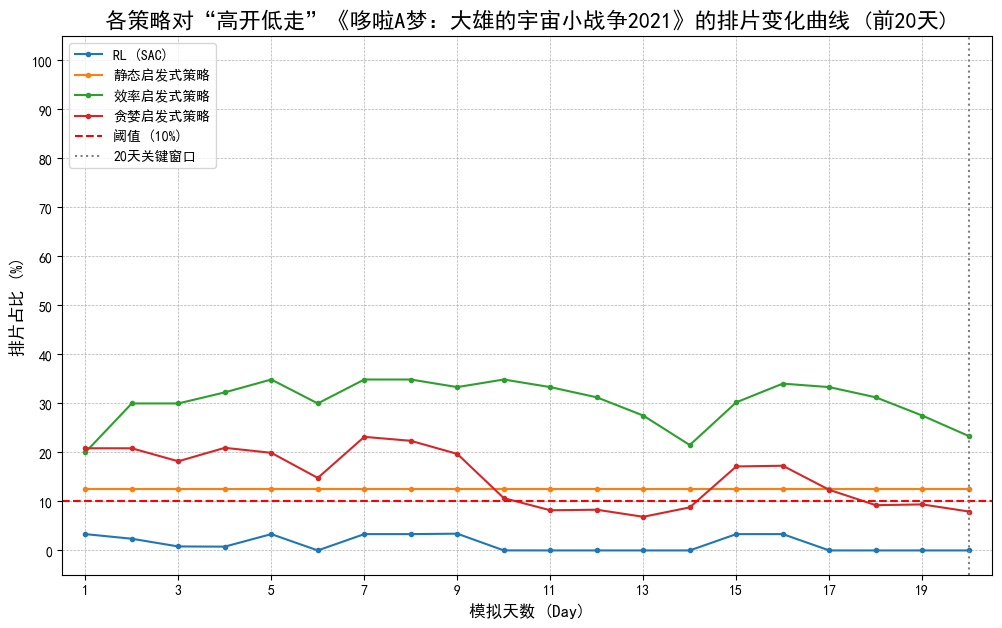


--- 案例分析：高开低走 - 《哆啦A梦：大雄与天空的理想乡》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
RL (SAC)     1.0
效率启发式策略      8.0
贪婪启发式策略     12.0
静态启发式策略      NaN
Name: 《哆啦A梦：大雄与天空的理想乡》 20天内止损速度 (天), dtype: float64
✅ 图表已保存至: ../plots\哆啦A梦大雄与天空的理想乡_cut_loss_speed_20d_20days_view.png


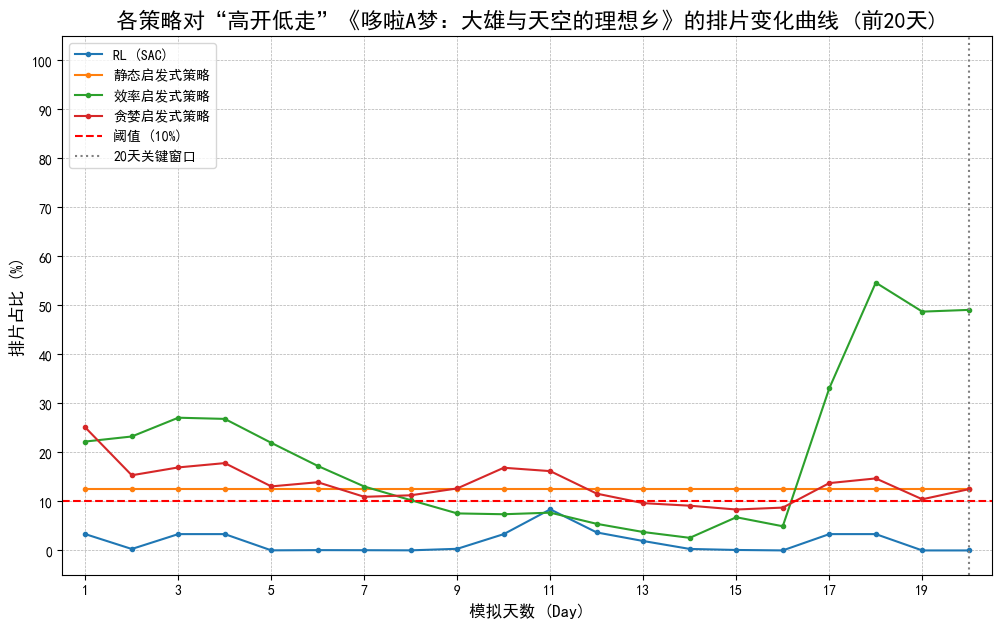


--- 案例分析：高开低走 - 《排球少年!! 垃圾场决战》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
RL (SAC)    1.0
效率启发式策略     2.0
贪婪启发式策略     NaN
静态启发式策略     NaN
Name: 《排球少年!! 垃圾场决战》 20天内止损速度 (天), dtype: float64
✅ 图表已保存至: ../plots\排球少年!! 垃圾场决战_cut_loss_speed_20d_20days_view.png


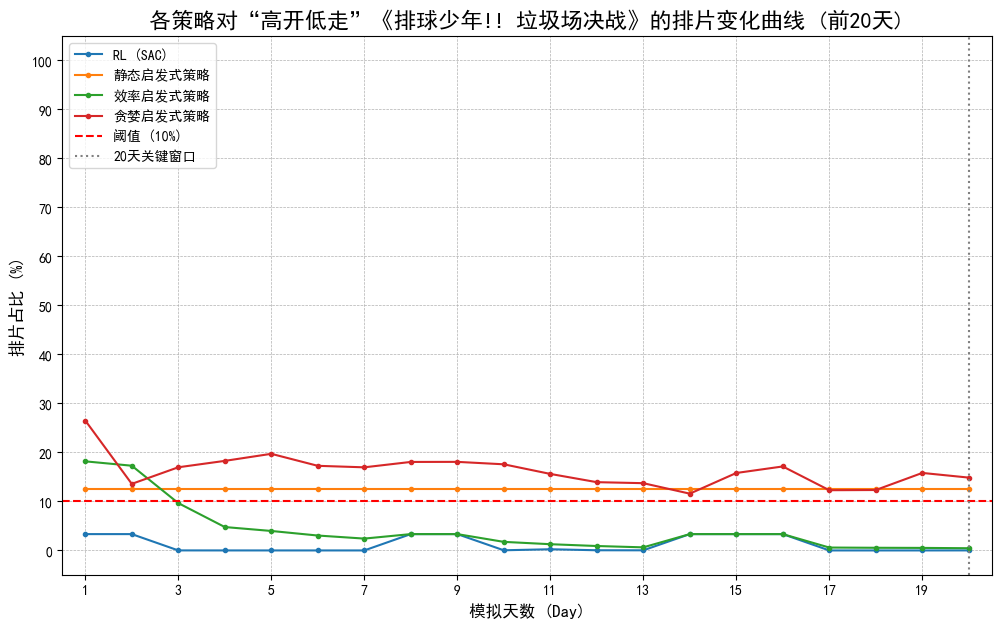


--- 案例分析：黑马 - 《流浪地球》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
RL (SAC)    1.0
效率启发式策略     1.0
贪婪启发式策略     1.0
静态启发式策略     NaN
Name: 《流浪地球》 20天内捕获速度 (天), dtype: float64
✅ 图表已保存至: ../plots\流浪地球_capture_speed_20d_20days_view.png


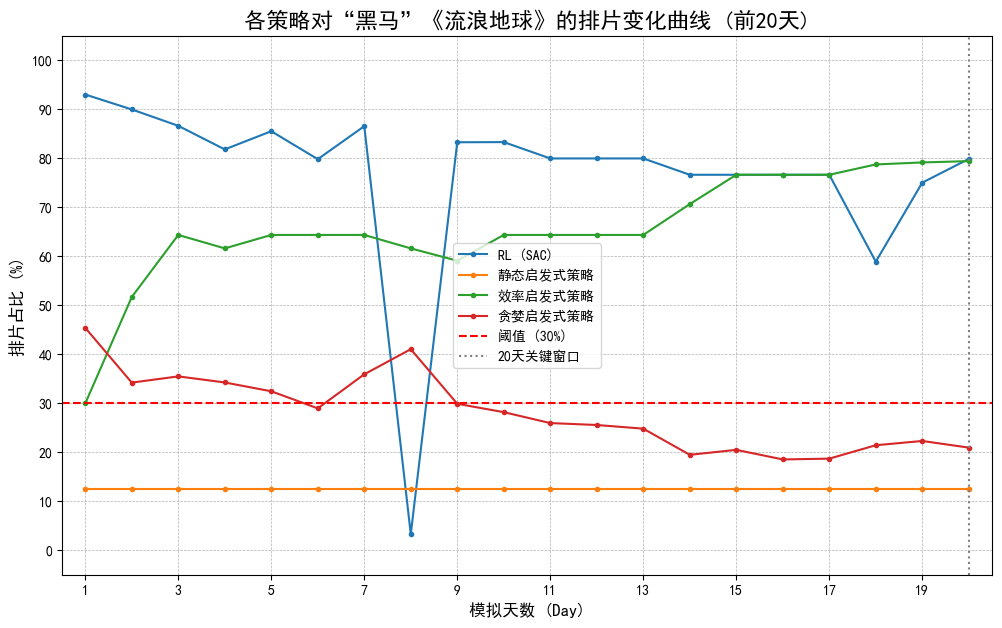


--- 案例分析：黑马 - 《刺杀小说家》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
效率启发式策略     2.0
RL (SAC)    NaN
贪婪启发式策略     NaN
静态启发式策略     NaN
Name: 《刺杀小说家》 20天内捕获速度 (天), dtype: float64
✅ 图表已保存至: ../plots\刺杀小说家_capture_speed_20d_20days_view.png


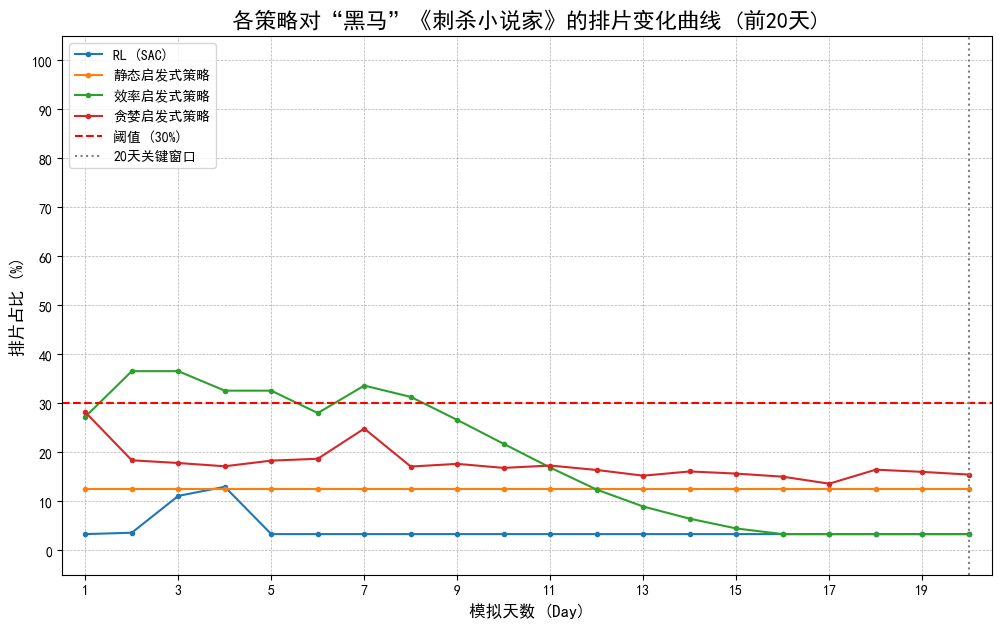


--- 案例分析：黑马 - 《这个杀手不太冷静》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
效率启发式策略     2.0
RL (SAC)    4.0
贪婪启发式策略     NaN
静态启发式策略     NaN
Name: 《这个杀手不太冷静》 20天内捕获速度 (天), dtype: float64
✅ 图表已保存至: ../plots\这个杀手不太冷静_capture_speed_20d_20days_view.png


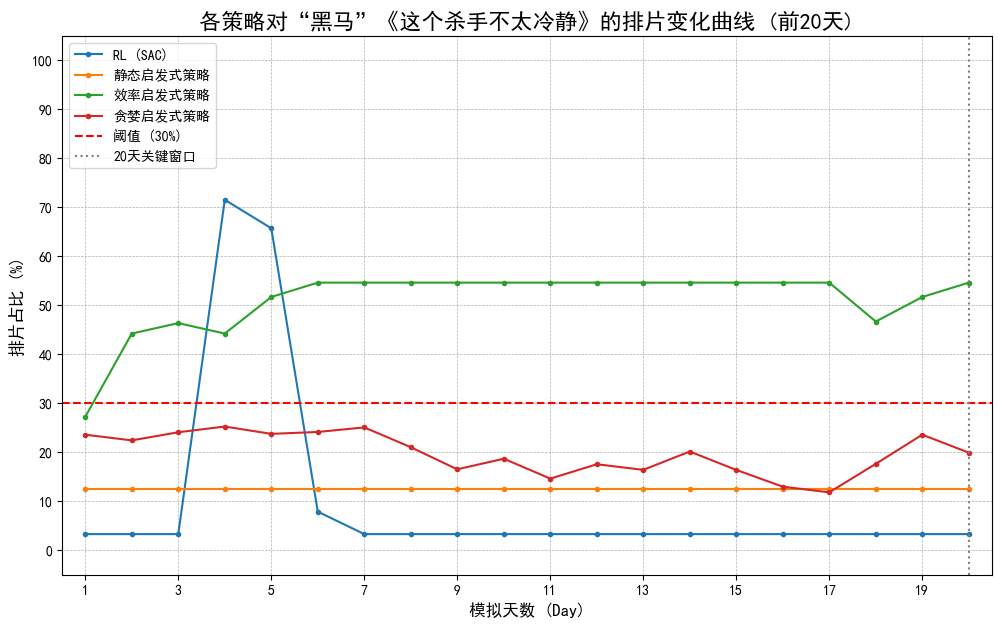


--- 案例分析：黑马 - 《熊出没·伴我“熊芯”》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
效率启发式策略     2.0
RL (SAC)    NaN
贪婪启发式策略     NaN
静态启发式策略     NaN
Name: 《熊出没·伴我“熊芯”》 20天内捕获速度 (天), dtype: float64
✅ 图表已保存至: ../plots\熊出没伴我“熊芯”_capture_speed_20d_20days_view.png


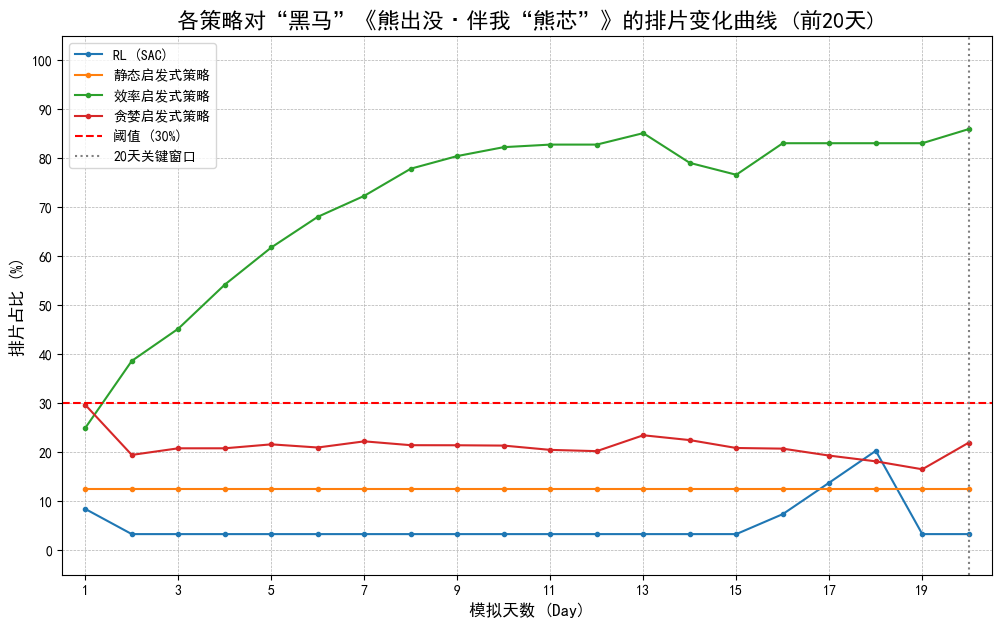


--- 案例分析：黑马 - 《人生路不熟》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
RL (SAC)    1.0
效率启发式策略     1.0
贪婪启发式策略     1.0
静态启发式策略     NaN
Name: 《人生路不熟》 20天内捕获速度 (天), dtype: float64
✅ 图表已保存至: ../plots\人生路不熟_capture_speed_20d_20days_view.png


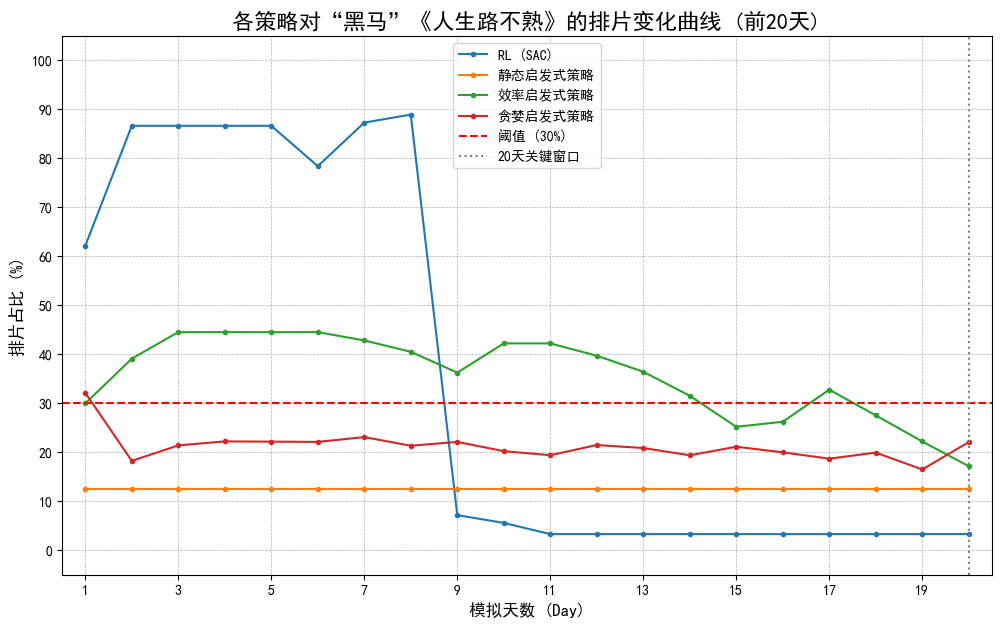


--- 案例分析：黑马 - 《坚如磐石》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
RL (SAC)    1.0
贪婪启发式策略     1.0
效率启发式策略     2.0
静态启发式策略     NaN
Name: 《坚如磐石》 20天内捕获速度 (天), dtype: float64
✅ 图表已保存至: ../plots\坚如磐石_capture_speed_20d_20days_view.png


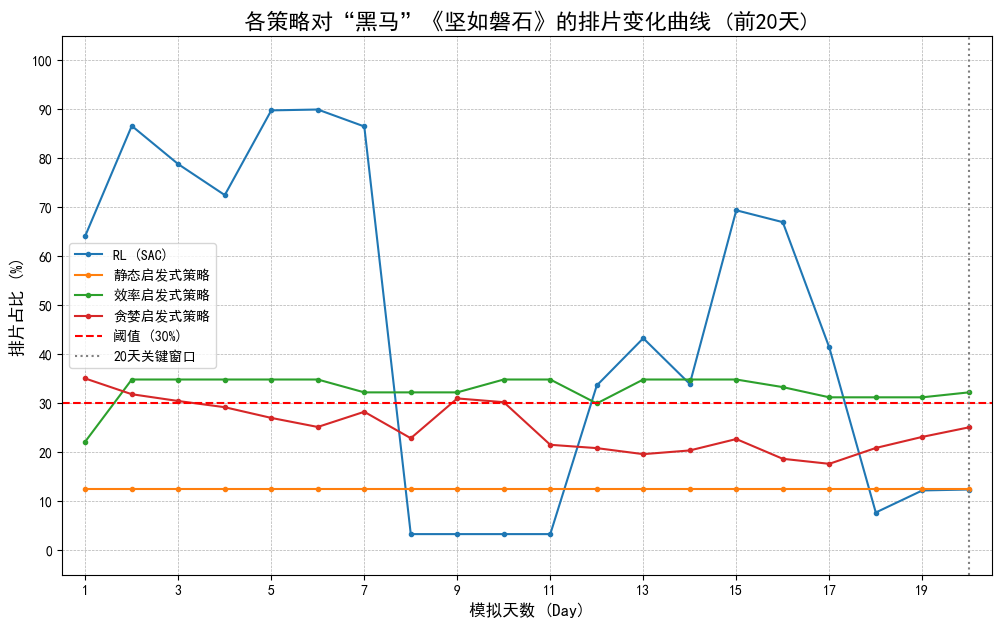


--- 案例分析：黑马 - 《熊出没·逆转时空》 ---
速度对比 (数值越小越好，NaN代表20天内未达标):
policy
贪婪启发式策略     1.0
效率启发式策略     2.0
RL (SAC)    NaN
静态启发式策略     NaN
Name: 《熊出没·逆转时空》 20天内捕获速度 (天), dtype: float64
✅ 图表已保存至: ../plots\熊出没逆转时空_capture_speed_20d_20days_view.png


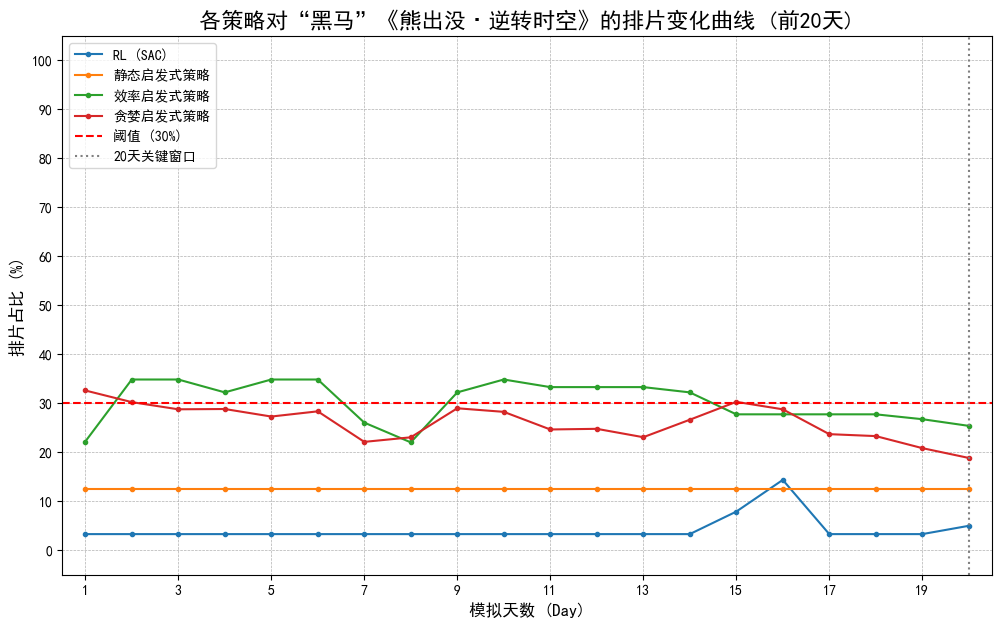


### 决策行为诊断指标分析 - 最终汇总 ###
评估标准：速度 (天)，数值越小越好，NaN代表在20天窗口期内未达标。

--- (1) “黑马”电影捕获速度 (天) ---
          流浪地球  刺杀小说家  这个杀手不太冷静  熊出没·伴我“熊芯”  熊出没·逆转时空  坚如磐石  人生路不熟
policy                                                            
RL (SAC)   1.0    NaN       4.0         NaN       NaN   1.0    1.0
效率启发式策略    1.0    2.0       2.0         2.0       2.0   2.0    1.0
贪婪启发式策略    1.0    NaN       NaN         NaN       1.0   1.0    1.0
静态启发式策略    NaN    NaN       NaN         NaN       NaN   NaN    NaN

--- (2) “高开低走”电影止损速度 (天) ---
          上海堡垒  1917  一秒钟  铁道英雄  神秘海域  哆啦A梦：大雄的宇宙小战争2021  哆啦A梦：大雄与天空的理想乡  排球少年!! 垃圾场决战
policy                                                                                
RL (SAC)   1.0   1.0  1.0   1.0   3.0                1.0             1.0           1.0
效率启发式策略    5.0   NaN  NaN   NaN   NaN                NaN             8.0           2.0
贪婪启发式策略    4.0   NaN  NaN   NaN   NaN               10.0            12.0           NaN
静态启发式策略    NaN   NaN  NaN   NaN   NaN    

In [33]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# (假设 df 变量已经从你之前的步骤加载完毕)
# (假设 plt, pd, np, os 已经导入)

def calculate_capture_speed(daily_actions, movie_index, threshold=0.40, max_days=None):
    """计算“黑马”捕获速度（天数），可选择性地限制在最大天数内评估。"""
    if movie_index is None or np.isnan(movie_index): return np.nan
    
    actions_to_check = daily_actions[:max_days] if max_days is not None else daily_actions

    for day, schedule in enumerate(actions_to_check):
        # 确保 schedule 是一个列表或 ndarray，并且索引在范围内
        if hasattr(schedule, '__len__') and len(schedule) > movie_index:
            if schedule[int(movie_index)] >= threshold:
                return day + 1
            
    if max_days is not None:
        return np.nan
    else:
        # 【修改】: 统一返回 NaN，表示未在窗口期内达标
        return np.nan

def calculate_cut_loss_speed(daily_actions, movie_index, threshold=0.05, max_days=None):
    """计算“高开低走影片”止损速度（天数），可选择性地限制在最大天数内评估。"""
    if movie_index is None or np.isnan(movie_index): return np.nan
    
    actions_to_check = daily_actions[:max_days] if max_days is not None else daily_actions

    for day, schedule in enumerate(actions_to_check):
        if hasattr(schedule, '__len__') and len(schedule) > movie_index:
            if schedule[int(movie_index)] <= threshold:
                return day + 1
            
    if max_days is not None:
        return np.nan
    else:
        # 【修改】: 统一返回 NaN，表示未在窗口期内达标
        return np.nan

# --- [ 步骤 4: 自动化决策行为诊断分析 ] ---
if not df.empty:
    case_study_runs = df.dropna(subset=['case_study_movie'])
    unique_cases = case_study_runs.drop_duplicates(subset=['start_date', 'case_study_movie'])

    plots_dir = '../plots'
    os.makedirs(plots_dir, exist_ok=True)
    all_speed_results = []

    print("\n" + "="*80)
    print("### 决策行为诊断指标分析 (关键窗口期：20天) ###")
    print("="*80)
    
    # 【修改】: 统一定义电影名单，以便后续汇总使用
    DARK_HORSE_MOVIES = [
         '流浪地球', '熊出没·原始时代', '新喜剧之王',
        '刺杀小说家', '人潮汹涌', '熊出没·狂野大陆',
        '这个杀手不太冷静', '熊出没·重返地球', '狙击手', '四海',
        '熊出没·伴我“熊芯”', '无名', '深海', '第二十条', '熊出没·逆转时空',
        '我和我的父辈', '坚如磐石', '前任4：英年早婚', '志愿军：雄兵出击', '莫斯科行动',
        '悬崖之上', '人生路不熟', '末路狂花钱', '九龙城寨之围城',
        '封神第一部：朝歌风云', '长安三万里', '学爸', '异形：夺命舰',
        '比悲伤更悲伤的故事', '我的姐姐', '扬名立万', '金手指', '周处除三害', '你想活出怎样的人生'
    ]
    
    FLOP_MOVIES = [
        '上海堡垒', '1917', '一秒钟', '铁道英雄', '神秘海域', 
        '哆啦A梦：大雄的宇宙小战争2021', '哆啦A梦：大雄与天空的理想乡', '排球少年!! 垃圾场决战'
    ] # (基于你上次的列表)
    
    for index, case_info in unique_cases.iterrows():
        case_name = case_info['case_study_movie']
        case_date = case_info['start_date']
        
        case_df = df[df['start_date'] == case_date].copy()
        
        # 【修改】: 使用 if...elif...else continue 结构，跳过 'None'
        if case_name in DARK_HORSE_MOVIES:
            case_type = '黑马'
            metric_func = calculate_capture_speed
            threshold = 0.30
            unit = '20天内捕获速度 (天)'
            metric_col_name = "capture_speed_20d"
            case_df[metric_col_name] = case_df.apply(lambda row: metric_func(row['daily_actions'], row['case_study_index'], threshold, max_days=20), axis=1)
        
        elif case_name in FLOP_MOVIES:
            case_type = '高开低走'
            metric_func = calculate_cut_loss_speed
            threshold = 0.10
            unit = '20天内止损速度 (天)'
            metric_col_name = "cut_loss_speed_20d"
            case_df[metric_col_name] = case_df.apply(lambda row: metric_func(row['daily_actions'][1:], row['case_study_index'], threshold, max_days=20), axis=1)
        
        else:
            # 如果电影不是“黑马”或“高开低走”（例如 'None'），则跳过本轮循环
            continue

        print(f"\n--- 案例分析：{case_type} - 《{case_name}》 ---")
        speed_summary = case_df.groupby('policy')[metric_col_name].mean().sort_values()
        speed_summary.name = f"《{case_name}》 {unit}"
        all_speed_results.append(speed_summary)
        print(f"速度对比 (数值越小越好，NaN代表20天内未达标):")
        print(speed_summary)
        
        # --- [ 绘图部分 (最终修正版) ] ---
        fig, ax = plt.subplots(figsize=(12, 7))
        policies_to_plot = case_df['policy'].unique()

        for policy_name in policies_to_plot:
            run_data = case_df[case_df['policy'] == policy_name].iloc[0]
            movie_idx = run_data['case_study_index']
            if not np.isnan(movie_idx):
                movie_idx = int(movie_idx)
                if len(run_data['daily_actions'][0]) > movie_idx:
                    full_schedule_over_time = [s[movie_idx] * 100 for s in run_data['daily_actions']]
                    schedule_to_plot = full_schedule_over_time[:20]
                    days_to_plot = range(1, len(schedule_to_plot) + 1)
                    
                    ax.plot(days_to_plot, schedule_to_plot, marker='.', linestyle='-', label=policy_name)

        ax.axhline(y=threshold * 100, color='r', linestyle='--', label=f"阈值 ({threshold*100:.0f}%)")
        ax.axvline(x=20, color='grey', linestyle=':', label='20天关键窗口')

        ax.set_title(f"各策略对“{case_type}”《{case_name}》的排片变化曲线 (前20天)", fontsize=16)
        ax.set_xlabel('模拟天数 (Day)', fontsize=12)
        ax.set_ylabel('排片占比 (%)', fontsize=12)
        
        ax.set_xlim(0.5, 20.5)
        ax.set_xticks(np.arange(1, 21, 2))
        
        ax.set_ylim(-5, 105)
        ax.set_yticks(np.arange(0, 101, 10))

        ax.legend()
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        safe_case_name = case_name.replace('·', '').replace('：', '')
        file_name = f"{safe_case_name}_{metric_col_name}_20days_view.png"
        save_path = os.path.join(plots_dir, file_name)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ 图表已保存至: {save_path}")
        plt.show()

    # ========================= 【【 新增代码：步骤 5 (V4 - 已修复) 】】 =========================
    # 在所有日期循环结束后，打印汇总表
    print("\n" + "="*80)
    print("### 决策行为诊断指标分析 - 最终汇总 ###")
    print("="*80)
    print("评估标准：速度 (天)，数值越小越好，NaN代表在20天窗口期内未达标。")

    if all_speed_results:
        # 1. 合并所有 Series 为一个 DataFrame
        # 策略为行(index), 电影为列(columns)
        speed_df = pd.concat(all_speed_results, axis=1)
        
        # 2. 清理列名 (只保留电影名)
        speed_df.columns = speed_df.columns.str.split('《').str[1].str.split('》').str[0]
        
        # 3. 准备策略的显示顺序 (硬编码)
        policy_order = ["RL (SAC)", "预测-优化策略", "效率启发式策略", "贪婪启发式策略", "静态启发式策略"]
        
        # 【【修复点】】: 
        # 先过滤出在 speed_df.index 中真实存在的策略
        available_policies_in_order = [p for p in policy_order if p in speed_df.index]
        
        # 4. 筛选“黑马”电影并打印
        print("\n--- (1) “黑马”电影捕获速度 (天) ---")
        dark_horse_cols = [col for col in DARK_HORSE_MOVIES if col in speed_df.columns]
        if dark_horse_cols:
            # 【【修复点】】: 使用过滤后的 available_policies_in_order 进行 .loc 索引
            speed_df_dark_horse = speed_df.loc[available_policies_in_order, dark_horse_cols]
            print(speed_df_dark_horse.to_string())
        else:
            print("未找到“黑马”电影的分析数据。")

        # 5. 筛选“高开低走”电影并打印
        print("\n--- (2) “高开低走”电影止损速度 (天) ---")
        flop_cols = [col for col in FLOP_MOVIES if col in speed_df.columns]
        if flop_cols:
            # 【【修复点】】: 使用过滤后的 available_policies_in_order 进行 .loc 索引
            speed_df_flop = speed_df.loc[available_policies_in_order, flop_cols]
            print(speed_df_flop.to_string())
        else:
            print("未找到“高开低走”电影的分析数据。")
            
    else:
        print("没有可供汇总的案例分析数据。")
    
    print("="*80)
    # =========================================================================